### This notebook is used for creating the dataset of real guppies images to test the YOLO model on

In [1]:
import os
from google.cloud import vision

import pickle
import h5py

import numpy as np
import matplotlib.pyplot as plt
import random

# Our scripts
from Python_Helpers.image_loading import * 
from Python_Helpers.preprocessing import * 
from Python_Helpers.corrections import *
from Python_Helpers.ID_isolation import *
from Python_Helpers.YOLO import *
from Python_Helpers.ML_helper import *


os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"./guppies-test-4c48569421d8.json"

relevant_characters =  {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'B',10:'F',11:'G',12:'K',13:'N',14:'O',15:'P',16:'R',17:'S',18:'V',19:'W',20:'Y', 21:''}

client = vision.ImageAnnotatorClient()

In [7]:
### DON'T RERUN ###

# # Code that split the Manually_Labelled/New files into training and testing data.

# training_files = ListAvaliableFiles('guppy_images', prefix='Manually_Labelled/New', verbose=True)
# random.shuffle(training_files)

# train_files = training_files[:70000]
# test_files = training_files[70000:]

# with open('ML_Data/training_files.dat', 'wb') as writer:
#     pickle.dump(train_files, writer)

# with open('ML_Data/testing_files.dat', 'wb') as writer:
#     pickle.dump(test_files, writer)

In [2]:
# Load the training and testing data files (should have lengths 70000 and 28474 respectively).

with open('ML_Data/training_files.dat', 'rb') as reader:
    training_files = pickle.load(reader)

with open('ML_Data/testing_files.dat', 'rb') as reader:
    testing_files = pickle.load(reader)

len(training_files), len(testing_files)

(70000, 28474)

In [3]:
# Function returns just the ID image. Can be used to check the ID_isolation process.
def ImageFunction(image_in_bytes, padx=80, pady=20, delta_width=10, verbose=False):
    # Initial google read and preprocessing of image.
    Initial_Results = GoogleRead(image_in_bytes, verbose=verbose)
    Processed_Results, title, ID, date = PreprocessLabel(Initial_Results, verbose=verbose)

    # Corrected google prediction.
    title, ID, date = CorrectOutput(title, ID, date)

    # Identity isolation
    ID_Dictionary = IsolateIdentity(Processed_Results, padx=padx, pady=pady, delta_width=delta_width, verbose=verbose)

    return '-'.join([title, ID, date]), ID_Dictionary['frame']


def extract_ID(training_files):
    #extract the IDs from the filenames.
    
    id_list = []
    for f in training_files:
        f = f.split('/')[-1].split('.')[0]
        
        if 's' in f:
            f = f.split('s')[0]

        if '(' in f: #this is something where the file has a (1) in it.
            f = f.split('(')[0][:-1]
            
        title = f[:3]
        date = f[-4:]
        id = f[3:-4]
        id_list.append(id)

    return id_list

IDs = np.array(extract_ID(training_files))

maxlen = np.max([len(IDs[i]) for i in range(len(IDs))])

c:\Users\newc6448\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


2B6P 2B6P


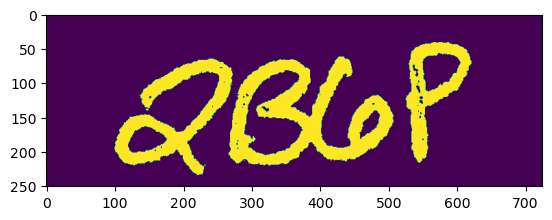

In [4]:
i=0
file = training_files[i]
image_in_bytes = RetreiveImageGoogle('guppy_images', file)
google_prediction, ID_image = ImageFunction(image_in_bytes, verbose=False)

google_prediction = google_prediction.split('-')[1]

plt.imshow(ID_image)
print(google_prediction, IDs[i])

In [5]:
string_to_vector(IDs[i], relevant_characters, max_len=maxlen), IDs[i]

(array([ 2,  9,  6, 15, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]),
 '2B6P')

In [6]:
h5f = h5py.File(('ML_Data/dataset.h5'), 'w')

image_width, image_height = 256, 64
   
file = training_files[0]
image_in_bytes = RetreiveImageGoogle('guppy_images', file)
google_prediction, ID_image = ImageFunction(image_in_bytes, verbose=False)

label_ID = IDs[0]

first_image = preprocess_image(ID_image[...,None],(image_width,image_height)).numpy()[None,...,0]
first_label = string_to_vector(label_ID, relevant_characters,max_len=maxlen)[None]
first_label_googpred = string_to_vector(google_prediction.split('-')[1], relevant_characters,max_len=maxlen)[None]

h5f.create_dataset('images', data=first_image, compression="gzip", chunks=True, maxshape=(None,image_height,image_width))
h5f.create_dataset('labels', data=first_label, compression="gzip", chunks=True, maxshape=(None,maxlen))
h5f.create_dataset('labels_googpred', data=first_label_googpred, compression="gzip", chunks=True, maxshape=(None,maxlen))

<HDF5 dataset "labels_googpred": shape (1, 26), type "<i4">

In [7]:
training_files = training_files[:10]

some_im_IDs = []
some_label_IDs = []

idx = np.arange(0, len(training_files))
np.random.shuffle(idx)


for i in range(len(training_files)):
    st = str(i)
    try: 
        image_in_bytes = RetreiveImageGoogle('guppy_images', training_files[idx[i]])
        google_prediction, ID_image = ImageFunction(image_in_bytes, verbose=False)

        image = preprocess_image(ID_image[...,None],(image_width,image_height))[None,...,0]
        label = string_to_vector(IDs[idx[i]], relevant_characters, max_len=maxlen)[None]
        label_goog = string_to_vector(google_prediction.split('-')[1], relevant_characters, max_len=maxlen)[None]


        h5f['images'].resize((h5f['images'].shape[0] + 1),axis=0)
        h5f['images'][-1:] = image

        h5f['labels'].resize((h5f['labels'].shape[0] + 1),axis=0)
        h5f['labels'][-1:] = label

        h5f['labels_googpred'].resize((h5f['labels_googpred'].shape[0] + 1),axis=0)
        h5f['labels_googpred'][-1:] = label_goog


        st += ' success'

    except: st += ' fail'
    print(st)


print(f"a success rate of {len(h5f['images']) / (len(training_files)-1)  * 100} %")

h5f.close()
    

0 success
1 success
2 success
3 success
4 success
5 success
6 success
7 success
8 success
9 success
a success rate of 110.00000000000001 %


Text(0.5, 1.0, 'Google Prediction: 2Y8P\nCorrect Prediction:2Y8P')

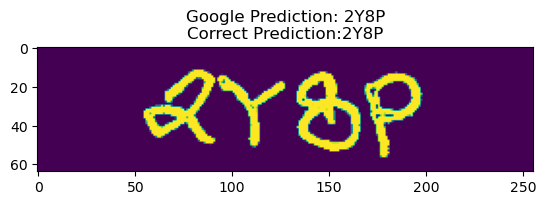

In [23]:
# Check the data in the data set for a random index
random_index = random.choice(range(10))
h5f = h5py.File(('ML_Data/dataset.h5'), 'r')

google_pred = ''.join(vector_to_string(h5f['labels_googpred'][random_index], relevant_characters))
correct = ''.join(vector_to_string(h5f['labels'][random_index], relevant_characters))

plt.imshow(h5f['images'][random_index])
plt.title('Google Prediction: ' + google_pred + '\nCorrect Prediction:' + correct)